In [3]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.optim as optim
import cellpylib as cpl
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Data Generation

In [5]:
def generate_binary_images(n):
    def generate_binary_images_recursive(current_image, remaining_pixels):
        if len(remaining_pixels) == 0:
            binary_images.append([row[:] for row in current_image])
            return

        current_pixel = remaining_pixels.pop()
        generate_binary_images_recursive(current_image, remaining_pixels.copy())  # Without changing the pixel
        current_image[current_pixel[0]][current_pixel[1]] = 1
        generate_binary_images_recursive(current_image, remaining_pixels.copy())  # Changing the pixel back
        current_image[current_pixel[0]][current_pixel[1]] = 0

    binary_images = []
    all_pixels = [(i, j) for i in range(n) for j in range(n)]
    generate_binary_images_recursive([[0] * n for _ in range(n)], all_pixels)
    
    return binary_images


In [6]:

def generate_all_states_2D(ca_size):

    # create all possible configurations of 0s and 1s
    def generate_all_possible_binary_images(ca_size):

        n_squares = ca_size**2

        if n_squares <= 0:
            return [[]]

        def backtrack(start, path, result):
            if len(path) == n_squares:
                
                # format into (ca_size, ca_size) 2D list
                result.append(path[:])
                return

            for i in range(start, 2):
                path.append(i)
                backtrack(0, path, result)
                path.pop()

        result = []
        backtrack(0, [], result)        
        return result

    
    all_binary_strings = generate_all_possible_binary_images(ca_size)
    input_data = np.zeros((2 ** (ca_size * ca_size), 1, ca_size, ca_size))
    for t in range(len(all_binary_strings)):
        binary_string = all_binary_strings[t]
        binary_image = [[]]
        for i in range(ca_size):
            binary_image[0].append(binary_string[ca_size*i:ca_size*(i+1)])
        input_data[t] = binary_image
    output_data = np.zeros((2 ** (ca_size * ca_size), 1, ca_size, ca_size))

    # randomize the order of the data
    np.random.shuffle(input_data)

    # evolve the data and set it as output data
    for t in range(len(input_data)):
        state = input_data[t]
        state = cpl.evolve2d(state, timesteps=2, neighbourhood='Moore', apply_rule=cpl.game_of_life_rule, memoize='recursive')
        output_data[t][0] = state[1]

    # convert data from numpy arrays to pytorch tensors
    input_data = torch.from_numpy(input_data).to(torch.float32)
    output_data = torch.from_numpy(output_data).to(torch.float32)
    
    return input_data, output_data

generate_all_states_2D(4)

KeyboardInterrupt: 

In [11]:
def generate_pairs_2D_rand(num_samples, ca_size):
    
    # Initialize dataset array
    input_data = torch.zeros((num_samples, 1, ca_size, ca_size))  
    output_data = torch.zeros((num_samples, 1, ca_size, ca_size))

    # ics = np.zeros((num_samples, ca_size, ca_size))
    
    for n in range(num_samples):

        # duplicate = True
        # while duplicate:
        ic = cpl.init_random2d(rows=ca_size-2, cols=ca_size-2)[0]
            # if np.array_equal(ics, ic) == False:
                # duplicate = False
                
        ca = np.array([np.pad(ic, pad_width=1, mode='constant', constant_values=0)])
        
        # evolve state for 3 time step based on update rule
        ca = cpl.evolve2d(ca, timesteps=2, apply_rule=cpl.game_of_life_rule, memoize=True)
        
        # convert the ca state from 0s and 1s to -1s and 1s
        # converted_ca = torch.where(torch.tensor(ca) == 0, -1, torch.tensor(ca))
        input_data[n] = torch.tensor(ca[0])
        
        output_data[n][0] = torch.tensor(ca[1])
        
    return input_data, output_data

In [7]:
x_data = torch.load('C:\\Users\\windows\\Research\\CA_Project\\datasets\\2d_GOL_input_data.pt')
y_data = torch.load('C:\\Users\\windows\\Research\\CA_Project\\datasets\\2d_GOL_output_data.pt')

print("x_data", x_data.size())
print("y_data", y_data.size())

x_data torch.Size([12000, 1, 9, 9])
y_data torch.Size([12000, 1, 9, 9])


In [8]:
print("x_data", x_data.size())
print(x_data)
print("y_data", y_data.size())
print(y_data)

x_data torch.Size([12000, 1, 9, 9])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 1., 0.],
          ...,
          [0., 1., 0.,  ..., 1., 1., 0.],
          [0., 0., 1.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 1., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 1., 1., 0.],
          ...,
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 1., 1., 0.],
          [0., 1., 1.,  ..., 0., 1., 0.],
          

## Split Data Into Training Set and Test Set

In [9]:
split = int(0.80 * len(x_data))
print(split)
x_train = x_data[:split]
y_train = y_data[:split]
x_test = x_data[split:]
y_test = y_data[split:]

9600


In [10]:
batch_size = 32

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Build Neural Network

In [29]:

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(1, 1))
        self.conv_final = nn.Conv2d(in_channels=5, out_channels=1, kernel_size=(1, 1))
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x
        
        # if I want to convert to binary numbers, then I can just do torch.round()
        # However, I should note that doing that here will destroy the gradient
        

In [30]:
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

print(model)

ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 5, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(5, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv_final): Conv2d(5, 1, kernel_size=(1, 1), stride=(1, 1))
)


## Optimization Loop

In [31]:
n_epochs = 50
for epoch in range(n_epochs):
    
    print("\n-------------------------------")
    
    # train loop
    model.train()
    for batch, (inputs, outputs) in enumerate(train_loader):
        
        inputs, outputs = inputs.to(device), outputs.to(device)
        
        # compute predictions
        predictions = model(inputs)
        
        # calculate loss
        loss = loss_fn(predictions, outputs)
        
        #backpropogation
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # print progress
        # if (batch+1) % 10 == 0:
            # print(f'Epoch [{epoch+1}/{n_epochs}], Step [{batch+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # writer.add_scalar("Training Loss", loss, global_step=step)
        # step += 1
        
            
    # test loop
    model.eval()
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        
        for inputs, outputs in test_loader:
            
            inputs, outputs = inputs.to(device), outputs.to(device)
            
            predictions = model(inputs)
            loss = loss_fn(predictions, outputs)
            test_loss += loss.item()
                
            # correct += (torch.round(predictions) == outputs).sum().item()
            for i in range(len(predictions)):
                rounded_prediction = torch.round(predictions[i])
                if rounded_prediction.equal(outputs[i]):
                    correct += 1
            
    average_test_loss = test_loss / len(test_loader)
    total = len(test_loader.dataset)
    accuracy = correct / total
    
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Test Loss: {average_test_loss:.4f}, Test Accuracy: {accuracy:.2%}')
    print('correct:', correct)
    print('total:', total)
    

    
print('Training and Testing finished.')


-------------------------------
Epoch [1/50], Test Loss: 0.5644, Test Accuracy: 0.00%
correct: 0
total: 2400

-------------------------------
Epoch [2/50], Test Loss: 0.4930, Test Accuracy: 0.00%
correct: 0
total: 2400

-------------------------------
Epoch [3/50], Test Loss: 0.0226, Test Accuracy: 82.33%
correct: 1976
total: 2400

-------------------------------
Epoch [4/50], Test Loss: 0.0130, Test Accuracy: 82.33%
correct: 1976
total: 2400

-------------------------------
Epoch [5/50], Test Loss: 0.0096, Test Accuracy: 82.33%
correct: 1976
total: 2400

-------------------------------
Epoch [6/50], Test Loss: 0.0071, Test Accuracy: 82.33%
correct: 1976
total: 2400

-------------------------------
Epoch [7/50], Test Loss: 0.0055, Test Accuracy: 82.33%
correct: 1976
total: 2400

-------------------------------
Epoch [8/50], Test Loss: 0.0043, Test Accuracy: 82.33%
correct: 1976
total: 2400

-------------------------------
Epoch [9/50], Test Loss: 0.0003, Test Accuracy: 100.00%
correct

In [32]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': n_epochs
}

# Specify the file path where you want to save the model
save_path = 'C:\\Users\\windows\\Research\\CA_Project\\pytorch_stuff\\models\\CNN_2D_GoL_Trained_Model.pth'

# Save the checkpoint
torch.save(checkpoint, save_path)

In [21]:
count = 0
for batch, (inputs, outputs) in enumerate(test_loader):
        if count < 1:
            inputs, outputs = inputs.to(device), outputs.to(device)
            
            input0 = inputs[0]
            print(input0.size())
            
            # compute predictions
            prediction = model(input0)
            rounded_prediction = torch.round(prediction)
            print(rounded_prediction)
            output0 = outputs[0]
            print(output0)
        count += 1

torch.Size([1, 9, 9])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')


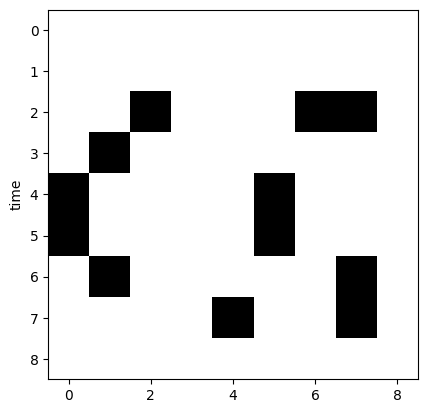

In [22]:
true_state = np.array(output0.cpu())
cpl.plot(true_state[0])

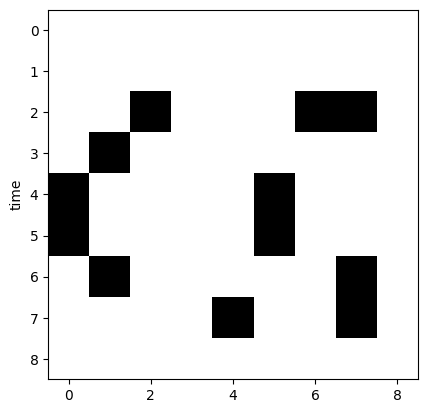

In [23]:
predicted_state = rounded_prediction.cpu().detach().numpy()
cpl.plot(predicted_state[0])

In [34]:
correct = 0
x_new, y_new = generate_pairs_2D_rand(num_samples=1, ca_size=9)

input_, output_ = x_new[0].to(device), y_new[0].to(device)
prediction = model(input_)
rounded_prediction = torch.round(prediction)


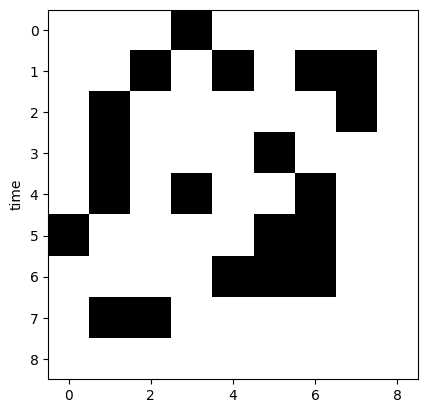

In [35]:
correct_state = np.array(output_.cpu())
cpl.plot(correct_state[0])

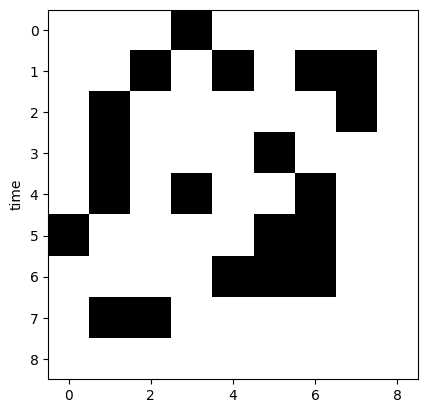

In [36]:
pred = rounded_prediction.cpu().detach().numpy()
cpl.plot(pred[0])

In [ ]:
model.

In [17]:
error = output_ - rounded_prediction
error

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<SubBackward0>)